In [35]:
import pickle
import numpy as np
import torchvision.models as models
import torch
from tensorflow.keras.utils import to_categorical
from PIL import Image

In [36]:
np.random.seed(20)
torch.random.manual_seed(20)

In [37]:
with open('/home/user01/tsign/data0.pickle', 'rb') as f:
    data = pickle.load(f)

In [38]:
x_train = data['x_train'].astype(np.float32)
y_train = data['y_train'].astype(np.float32)
x_test = data['x_test']
y_test = data['y_test']

In [39]:
print(x_train.shape)
print(y_train.shape)

(86989, 3, 32, 32)
(86989,)


In [40]:
np.unique(y_train)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42.], dtype=float32)

In [41]:
chosen_tr_ids = [idx for idx, (_x, _y) in enumerate(zip(x_train, y_train)) if _y in set([i for i in range(10)])]
chosen_te_ids = [idx for idx, (_x, _y) in enumerate(zip(x_test, y_test)) if _y in set([i for i in range(10)])]

In [42]:
len(chosen_tr_ids)

20230

In [43]:
len(chosen_te_ids)

4800

In [44]:
x_train = x_train[chosen_tr_ids]/255
y_train = y_train[chosen_tr_ids]
x_test = x_test[chosen_te_ids]/255
y_test = y_test[chosen_te_ids]

In [45]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [46]:
mean = (0.4914, 0.4822, 0.4465) 
std = (0.2023, 0.1994, 0.201)

In [47]:
resnet18 = models.resnet18(pretrained=True)

In [48]:
resnet18 = resnet18.to('cuda')

In [49]:
resnet18.fc = torch.nn.Linear(512, 10)

In [50]:
from art.estimators.classification import PyTorchClassifier
import torch.nn as nn
import torch.optim as optim

# Define the ART Estimator
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-4)
classifier = PyTorchClassifier(
    model=resnet18,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    preprocessing=(mean, std)
)

In [51]:
# Train the model

classifier.fit(x_train, y_train, nb_epochs=100, batch_size=128, verbose=True)
for param_group in classifier.optimizer.param_groups:
    print(param_group["lr"])
    param_group["lr"] *= 0.1
classifier.fit(x_train, y_train, nb_epochs=50, batch_size=128, verbose=True)
for param_group in classifier.optimizer.param_groups:
    print(param_group["lr"])
    param_group["lr"] *= 0.1
classifier.fit(x_train, y_train, nb_epochs=50, batch_size=128, verbose=True)
torch.save(resnet18.state_dict(), "htbd_my_model.pth") # Write the checkpoint to a temporary directory

0.01
0.001


In [52]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 95.5%


In [53]:
from art.attacks.poisoning.backdoor_attack import PoisoningAttackBackdoor
target = np.array([0,0,0,0,1,0,0,0,0,0])
source = np.array([0,0,0,1,0,0,0,0,0,0])

# Backdoor Trigger Parameters
patch_size = 8
x_shift = 32 - patch_size - 5
y_shift = 32 - patch_size - 5

# Define the backdoor poisoning object. Calling backdoor.poison(x) will insert the trigger into x.
from art.attacks.poisoning import perturbations
def mod(x):
    original_dtype = x.dtype
    x = perturbations.insert_image(x, backdoor_path="/home/user01/htbd.png",
                                   channels_first=True, random=False, x_shift=x_shift, y_shift=y_shift,
                                   size=(patch_size,patch_size), mode='RGB', blend=1)
    return x.astype(original_dtype)
backdoor = PoisoningAttackBackdoor(mod)

In [54]:
list(resnet18.children())[8]

AdaptiveAvgPool2d(output_size=(1, 1))

In [55]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [56]:
from art.attacks.poisoning import HiddenTriggerBackdoor
poison_attack = HiddenTriggerBackdoor(classifier, eps=16/255, target=target, source=source, feature_layer=8, backdoor=backdoor, decay_coeff = .95, decay_iter = 2000, max_iter=5000, batch_size=25, poison_percent=0.01)

poison_data, poison_indices = poison_attack.poison(x_train, y_train)
print("Number of poison samples generated:", len(poison_data))

Hidden Trigger:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0 | i:     0 |                         LR: 0.00100 |                         Loss Val: 13126.870 | Loss Avg: 13126.870
Batch: 0 | i:   100 |                         LR: 0.00100 |                         Loss Val: 77.713 | Loss Avg: 575.085
Batch: 0 | i:   200 |                         LR: 0.00100 |                         Loss Val: 34.556 | Loss Avg: 311.228
Batch: 0 | i:   300 |                         LR: 0.00100 |                         Loss Val: 26.980 | Loss Avg: 216.817
Batch: 0 | i:   400 |                         LR: 0.00100 |                         Loss Val: 16.824 | Loss Avg: 167.790
Batch: 0 | i:   500 |                         LR: 0.00100 |                         Loss Val: 14.002 | Loss Avg: 137.588
Batch: 0 | i:   600 |                         LR: 0.00100 |                         Loss Val: 12.695 | Loss Avg: 117.099
Batch: 0 | i:   700 |                         LR: 0.00100 |                         Loss Val: 11.123 | Loss Avg: 102.257
Batch: 0 | i:   800 |      

In [57]:
poison_data.shape

(21, 3, 32, 32)

In [58]:
poison_indices

array([ 1782, 11411, 16112, 10689,  9323, 17419,  1588, 17019,  1308,
       13227, 13367, 14327,  5483, 15816,  4038, 12379, 14463, 20107,
       17098,  8734, 14614])

In [59]:
type(poison_data[0])

numpy.ndarray

In [60]:
# Create finetuning dataset
dataset_size = 2500
num_classes = 10
num_per_class = dataset_size/num_classes

poison_dataset_inds = []

for i in range(num_classes):
    class_inds = np.where(np.argmax(y_train,axis=1) == i)[0]
    num_select = int(num_per_class)
    if np.argmax(target) == i:
        num_select = int(num_select - len(poison_data))
        poison_dataset_inds.append(poison_indices)
    poison_dataset_inds.append(np.random.choice(class_inds, num_select, replace=False))
    
poison_dataset_inds = np.concatenate(poison_dataset_inds)

poison_x = np.copy(x_train)
poison_x[poison_indices] = poison_data
poison_x = poison_x[poison_dataset_inds]

poison_y = np.copy(y_train)[poison_dataset_inds]

In [72]:
num_poisons = len(poison_indices)
first_poison_idx = list(poison_dataset_inds).index(poison_indices[0])
poison_indices_in_ft = [i for i in range(first_poison_idx, first_poison_idx+num_poisons)]

In [73]:
poison_indices_in_ft

[1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020]

In [74]:
# res = {'x':poison_x, 'y':poison_y, 'poison_idxs':poison_indices_in_ft}

In [75]:
# with open('res.pkl','wb') as file:
#     pickle.dump(res, file)

In [61]:
new_poison_indices = []
poison_indices_set = set(poison_indices)
for i, idx in enumerate(poison_dataset_inds):
    if idx in poison_indices_set:
        new_poison_indices.append(i)

In [62]:
new_poison_indices

[1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1075,
 1083]

In [63]:
poison_x.shape

(2500, 3, 32, 32)

In [64]:
poison_y.shape

(2500, 10)

In [65]:
np.unique([np.argmax(item) for item in poison_y])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [66]:
model = models.resnet18(pretrained=True)
model = model.to('cuda')
model.fc = torch.nn.Linear(512, 10)

In [67]:
model.load_state_dict(torch.load("htbd_my_model.pth"))

<All keys matched successfully>

In [68]:

# temp_model_dir.cleanup() # Remove the temporary directory after loading the checkpoint

# Freeze the layers up to the last layer
for i, param in enumerate(model.parameters()):
    param.requires_grad = False


num_classes=10
model.fc = torch.nn.Linear(512, 10)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=2e-4)

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
    preprocessing=(mean, std)
)


In [69]:
trigger_test_inds = np.where(np.all(y_test == source, axis=1))[0]

lr_factor = .1
lr_schedule = [5, 10, 15]

test_poisoned_samples, test_poisoned_labels  = backdoor.poison(x_test[trigger_test_inds], y_test[trigger_test_inds])

for i in range(4):
    print("Training Epoch", i*5)
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    print("Accuracy on benign test examples: {}%".format(accuracy * 100))
    
    predictions = classifier.predict(x_test[trigger_test_inds])
    b_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[trigger_test_inds], axis=1)) / len(trigger_test_inds)
    print("Accuracy on benign trigger test examples: {}%".format(b_accuracy * 100))
    
    predictions = classifier.predict(test_poisoned_samples)
    p_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(test_poisoned_labels,axis=1)) / len(test_poisoned_labels)
    print("Accuracy on poison trigger test examples: {}%".format(p_accuracy * 100))
    p_success = np.sum(np.argmax(predictions, axis=1) == np.argmax(target)) / len(test_poisoned_labels)
    print("Success on poison trigger test examples: {}%".format(p_success * 100))
    print()
    if i != 0:
        for param_group in classifier.optimizer.param_groups:
            param_group["lr"] *= lr_factor
    classifier.fit(poison_x, poison_y, epochs=5, training_mode=False)

Training Epoch 0
Accuracy on benign test examples: 19.041666666666668%
Accuracy on benign trigger test examples: 1.1111111111111112%
Accuracy on poison trigger test examples: 5.111111111111112%
Success on poison trigger test examples: 56.00000000000001%

Training Epoch 5
Accuracy on benign test examples: 94.91666666666667%
Accuracy on benign trigger test examples: 92.66666666666666%
Accuracy on poison trigger test examples: 19.555555555555557%
Success on poison trigger test examples: 68.0%

Training Epoch 10
Accuracy on benign test examples: 94.85416666666666%
Accuracy on benign trigger test examples: 92.22222222222223%
Accuracy on poison trigger test examples: 10.666666666666668%
Success on poison trigger test examples: 77.77777777777779%

Training Epoch 15
Accuracy on benign test examples: 94.85416666666666%
Accuracy on benign trigger test examples: 92.22222222222223%
Accuracy on poison trigger test examples: 10.666666666666668%
Success on poison trigger test examples: 77.77777777777

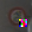

In [70]:
Image.fromarray(np.uint8(test_poisoned_samples[0]*255).transpose(2,1,0), 'RGB')

In [71]:
print("Final Performance")
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

predictions = classifier.predict(x_test[trigger_test_inds])
b_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[trigger_test_inds], axis=1)) / len(trigger_test_inds)
print("Accuracy on benign trigger test examples: {}%".format(b_accuracy * 100))

predictions = classifier.predict(test_poisoned_samples)
p_accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[trigger_test_inds],axis=1)) / len(trigger_test_inds)
print("Accuracy on poison trigger test examples: {}%".format(p_accuracy * 100))
p_success = np.sum(np.argmax(predictions, axis=1) == np.argmax(target)) / len(trigger_test_inds)
print("Success on poison trigger test examples: {}%".format(p_success * 100))

Final Performance
Accuracy on benign test examples: 94.85416666666666%
Accuracy on benign trigger test examples: 92.22222222222223%
Accuracy on poison trigger test examples: 10.666666666666668%
Success on poison trigger test examples: 77.77777777777779%


In [77]:
# torch.save(model, 'traffic-model.pt')

In [78]:
# model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from cv2 import resize

In [ ]:
x_train[0].shape

In [ ]:
x_train[0].transpose(2,1,0).shape

In [ ]:
def regen_img(img, from_size, to_size):
    img = img.transpose(2,1,0)
    img = resize(img, to_size)
    img = resize(img, from_size)
    return img

In [ ]:
def get_compressed_outputs(img, from_size, to_sizes):
    preds = []
    for curr_size in to_sizes:
        curr_img = regen_img(img, from_size, curr_size)
        preds.append(classifier.predict(curr_img.reshape(-1,3,32,32)))
    preds = np.array(preds).squeeze()
    return preds

In [ ]:
y_train[0]

In [ ]:
classifier.predict(poison_x[0]).argmax(axis=1)

In [ ]:
from scipy.stats import mode

In [ ]:
poison_y[20]

In [ ]:
get_compressed_outputs(poison_x[500], (32,32), [(24,24),(15,15),(20,20),(22,22),(10,10)]).argmax(axis=1)

In [ ]:
idx = 50
val1 = mode(get_compressed_outputs(poison_x[idx], (32,32), [(24,24),(15,15),(20,20),(22,22),(10,10)]).argmax(axis=1),
            keepdims=False)[0]
val2 = classifier.predict(poison_x[idx]).argmax(axis=1)
val1 == val2

In [ ]:
poison_x.shape

In [ ]:
classifier.predict(regen_img(x_train[0], (32,32), (24,24)).reshape(-1,3,32,32))

In [ ]:
Image.fromarray(np.uint8(regen_img(x_train[0], (32,32), (24,24))*255), 'RGB')

In [ ]:
temp_x = resize(resize(x_train[0].transpose(2,1,0), (25,25)), (32,32))

In [ ]:
temp_x.shape

In [ ]:
temp_x.max()

In [ ]:
Image.fromarray(np.uint8(temp_x*255), 'RGB')

In [ ]:
Image.fromarray(np.uint8(x_train[1]*255).transpose(2,1,0), 'RGB')

In [ ]:
poison_y.shape

In [ ]:
poison_x.shape

In [ ]:
poison_y[:5]

In [ ]:
from scipy.special import softmax

In [ ]:
poison_x[0][0].shape

In [ ]:
tmp = np.array([softmax(classifier.predict(_x[0])) for i, _x in enumerate(poison_x)]).squeeze().max(axis=1)

In [ ]:
tmp.shape

In [ ]:
softmax(classifier.predict(poison_x))[:10]

In [ ]:
softmax(classifier.predict(poison_x[2]))

In [ ]:
poison_y_pred_conf = np.array([softmax(classifier.predict(_x[0])) for i, _x in enumerate(poison_x)]).squeeze().max(axis=1)

In [ ]:
np.where(poison_y_pred_conf<0.8)[0]

In [ ]:
bad_lst = set([1000,
 1001,
 1002,
 1003,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1017,
 1018,
 1019,
 1020,
 1084,
 1094,
 1113,
 1132,
 1143])

In [ ]:
set(np.where(poison_y_pred_conf<0.98)[0]).intersection(bad_lst)

In [ ]:
poison_y_pred = classifier.predict(poison_x).argmax(axis=1)

In [ ]:
poison_y_pred

In [ ]:
poison_y_true = poison_y.argmax(axis=1)

In [ ]:
poison_y_true

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

In [ ]:
classifier.layer_names

In [ ]:
return_nodes = {
    "avgpool": "avgpool"
}
model2 = create_feature_extractor(model, return_nodes=return_nodes)
model2 = model2.to('cuda')

In [ ]:
model2

In [ ]:
x_train[:5].astype('float32')

In [ ]:
model2(torch.Tensor(x_train[:5].astype('float32')).to('cuda'))['avgpool'].shape

In [ ]:
model2(torch.Tensor(x_train[5].astype('float32')).reshape(-1,3,32,32).to('cuda'))['avgpool'].shape

In [ ]:
x_p = np.copy(poison_data)
y_p = y_train[poison_indices]

In [ ]:
x_p.shape

In [ ]:
y_p.shape

In [ ]:
y_c = [np.argmax(_y) for _y in y_train]

In [ ]:
y_p = [np.argmax(_y) for _y in y_p]

In [ ]:
y_p

In [ ]:
y_p_tmp = np.array([10 for _y in y_p])

In [ ]:
y_p_tmp.shape

In [ ]:
def get_repr(x):
    return model2(torch.Tensor(x.astype('float32')).reshape(-1,3,32,32).to('cuda'))['avgpool'].squeeze().cpu().numpy()

In [ ]:
get_repr(x_train[5:10]).shape

In [ ]:
get_repr(x_train)

In [ ]:
poison_indices

In [ ]:
Image.fromarray(np.uint8(x_train[1651]*255).transpose(2,1,0), 'RGB')

In [ ]:
Image.fromarray(np.uint8(x_p[1]*255).transpose(2,1,0), 'RGB')

In [ ]:
rep_train = get_repr(x_train)
pois_train = get_repr(x_p)

In [ ]:
rep_train.shape

In [ ]:
pois_train.shape

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
rep_all = np.concatenate((rep_train, pois_train), axis=0)

# Plot 3d

In [ ]:
# rep_reduced = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=3).fit_transform(rep_all)

In [ ]:
# rep_reduced.shape

In [ ]:
y_all = np.concatenate((y_c, y_p), axis=0)

In [ ]:
# y_all.shape

In [ ]:
import plotly.express as px

In [ ]:
import pandas as pd

In [ ]:
# df = pd.DataFrame({'dim1': rep_reduced[:, 0], 'dim2': rep_reduced[:, 1], 'dim3': rep_reduced[:, 2]})
# df['label'] = y_all
# df.head()

In [ ]:
# fig = px.scatter_3d(df, x = 'dim1',
#                     y = 'dim2',
#                     z = 'dim3',
#                     color = 'label') 
# fig.show()

In [ ]:
# fig = px.scatter_3d(df[df['label']==4], x = 'dim1',
#                     y = 'dim2',
#                     z = 'dim3',
#                     color = 'label') 
# fig.show()

In [ ]:
# df2 = pd.DataFrame({'dim1': rep_reduced[:, 0], 'dim2': rep_reduced[:, 1], 'dim3': rep_reduced[:, 2]})
# df2['label'] = np.concatenate((y_c, y_p_tmp), axis=0)
# df2.head()

In [ ]:
# fig = px.scatter_3d(df2[df2['label'].isin({4,10})], x = 'dim1',
#                     y = 'dim2',
#                     z = 'dim3',
#                     color = 'label') 
# fig.show()

# Plot 2d

In [ ]:
rep_reduced = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(rep_all)

In [ ]:
df3 = pd.DataFrame({'dim1': rep_reduced[:, 0], 'dim2': rep_reduced[:, 1]})
df3['label'] = y_all
df3.head()

In [ ]:
fig = px.scatter(df3, x = 'dim1',
                    y = 'dim2',
                    color = 'label') 
fig.show()

In [ ]:
df4 = pd.DataFrame({'dim1': rep_reduced[:, 0], 'dim2': rep_reduced[:, 1]})
df4['label'] = np.concatenate((y_c, y_p_tmp), axis=0)
df4.head()

In [ ]:
fig = px.scatter(df4[df4['label'].isin({4,10})], x = 'dim1',
                    y = 'dim2',
                    color = 'label') 
fig.show()

In [ ]:
fig = px.scatter(df4, x = 'dim1',
                    y = 'dim2',
                    color = 'label') 
fig.show()

In [ ]:
len(df4)

In [ ]:
fig = px.scatter(df4[df4['label'].isin({4})], x = 'dim1',
                    y = 'dim2',
                    color = 'label') 
fig.show()

In [ ]:
df4[df4['label']==4][['dim1','dim2']].to_numpy().mean(axis=0)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
x2d = df3[['dim1','dim2']].to_numpy()

In [ ]:
x2d.shape

In [ ]:
x2d[:5]

In [ ]:
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels = clusterer.fit_predict(x2d)

In [ ]:
cluster_labels.shape

In [ ]:
cluster_labels[:10]

In [ ]:
(cluster_labels==1).sum()

In [ ]:
chosen_indices = {i:np.random.choice(np.where(np.array(y_c)==i)[0].squeeze(), 50) for i in range(10)}

In [ ]:
trusted_centers = {i:rep_reduced[chosen_indices[i]].mean(axis=0) for i in range(10)}

In [ ]:
trusted_centers[4]

In [ ]:
np.array(list(trusted_centers.values())).shape

In [ ]:
rep_reduced.shape

In [ ]:
from scipy.spatial import distance

In [ ]:
distances = distance.cdist(rep_reduced, np.array(list(trusted_centers.values())), 'euclidean')

In [ ]:
distances.shape

In [ ]:
distances[-1]

In [ ]:
distances[-2]

In [ ]:
distances[-3]

In [ ]:
distances[-4]

In [ ]:
distances[-5]

In [ ]:
for i in range(21):
    print(distances[-i][4])
    print(np.delete(distances[-i], 4).min())
    print('----')

In [ ]:
idxs = np.random.choice(np.where(np.array(y_c)==4)[0], 100).squeeze()

In [ ]:
idxs

In [ ]:
idxs = np.random.choice(np.where(np.array(y_c)==4)[0], 10).squeeze()
for i in idxs:
    print(distances[i][4])
    print(np.delete(distances[i], 4).min())
    print('----')

In [ ]:
distances[0]

In [ ]:
distances[14]

In [ ]:
np.where(np.array(y_c)==4)

In [ ]:
rep_reduced.shape

In [ ]:
y_all.shape

In [ ]:
untrusted_centers = {i:rep_reduced[np.where(y_all==i)[0]].mean(axis=0) for i in range(10)}

In [ ]:
untrusted_centers[4]

In [ ]:
distances_un = distance.cdist(rep_reduced, np.array(list(untrusted_centers.values())), 'euclidean')

In [ ]:
distances_un.shape

In [ ]:
for i in range(21):
    print(distances_un[-i][4])
    print(np.delete(distances_un[-i], 4).min())
    print('----')

In [ ]:
idxs2 = np.random.choice(np.where(np.array(y_c)==4)[0], 10).squeeze()
for i in idxs:
    print(distances_un[i][4])
    print(np.delete(distances_un[i], 4).min())
    print('----')

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
t_std = {i:distances[:,i].std() for i in range(10)}
un_std = {i:distances_un[:,i].std() for i in range(10)}

In [ ]:
un_dists = []
t_dists = []
for i, (_x,_y) in enumerate(zip(rep_reduced, y_all)):
    un_center_dst = distances_un[i][_y]
    un_center_dst_others = np.delete(distances_un[i], _y).min()
    t_center_dst = distances[i][_y]
    t_center_dst_others = np.delete(distances[i], _y).min()
    un_dists.append(abs(un_center_dst-un_center_dst_others))
    t_dists.append(abs(t_center_dst-t_center_dst_others))

In [ ]:
un_dists[:10]

In [ ]:
un_lst = {i:[] for i in range(10)}
t_lst = {i:[] for i in range(10)}
for i, (_x,_y) in enumerate(zip(rep_reduced, y_all)):
    un_lst[_y].append(un_dists[i])
    t_lst[_y].append(t_dists[i])

In [ ]:
np.array(un_lst[4]).std()

In [ ]:
un_dst_std = {i:np.array(un_lst[i]).std() for i in range(10)}
t_dst_std = {i:np.array(t_lst[i]).std() for i in range(10)}

In [ ]:
un_dst_std[4]

In [ ]:
print(1)

In [ ]:
bad_un_idxs = [i for i, (item, _y) in enumerate(zip(un_dists, y_all)) if item>un_dst_std[_y]*3]
bad_t_idxs = [i for i, (item, _y) in enumerate(zip(t_dists, y_all)) if item>t_dst_std[_y]*3]

In [ ]:
set(range(20231,20252))

In [ ]:
len(bad_un_idxs)

In [ ]:
len(bad_t_idxs)

In [ ]:
len(list(set(bad_un_idxs).intersection(set(bad_t_idxs))))

In [ ]:
detected_poison_idxs = set(bad_un_idxs).intersection(set(bad_t_idxs))

In [ ]:
set(range(20231,20252)).intersection(set(bad_un_idxs).intersection(set(bad_t_idxs)))

In [ ]:
print(1)

In [ ]:
torch.cuda.empty_cache()